In [2]:
# https://openrouteservice.org/
# https://openrouteservice.org/dev/#/api-docs/v2/directions/{profile}/get

# username = dconly
# email = dconly@sacog.org

import requests
import os

import geopandas as gpd
import arcpy
arcpy.env.overwriteOutput = True

api_key_source = r"C:\Users\dconly\GitRepos\GIS-tools\ORS\api2_DO_NOT_COMMIT.txt"
with open(api_key_source) as f:
    ors_api_key = f.readline()







In [3]:
src = r'I:\Projects\Darren\PEP\PEP_GIS\PEP_GIS.gdb\test_sr51'
dest = os.path.join(arcpy.env.scratchGDB, 'TEST_sr51')

arcpy.management.CopyFeatures(src, dest)

<Result 'C:\\Users\\dconly\\AppData\\Local\\Temp\\scratch.gdb\\TEST_sr51'>

In [4]:
# Make isochrone around multiple points along a line
# https://openrouteservice.org/dev/#/api-docs/isochrones

# input project line feature class
line_fc = r"I:\Projects\Darren\PEP\PEP_GIS\PEP_GIS.gdb\test_sr51"
sref_wgs84 = arcpy.SpatialReference(4326)


# make temporary feature class of points at regular intervales along lines
# FYI, time permitting, the shapely library has some options for doing this that *might* be faster than ESRI tool
temp_pt_fc = os.path.join(arcpy.env.scratchGDB, "TEMP_pts")
arcpy.management.GeneratePointsAlongLines(line_fc, 
                                          temp_pt_fc, "DISTANCE", 
                                          Distance="1000 feet", 
                                          Include_End_Points="END_POINTS")

# calc x/y coords in WGS84 (WKID 4326) for compatibility with ORS API
pt_fl = "pt_fl"
arcpy.MakeFeatureLayer_management(temp_pt_fc, pt_fl)
arcpy.AddGeometryAttributes_management(Input_Features=pt_fl, 
                                       Geometry_Properties=['POINT_X_Y_Z_M'],
                                      Coordinate_System=sref_wgs84)

# print([f.name for f in arcpy.ListFields(temp_pt_fc)])

# make array of points at regular intervals along line to
line_pts = []
with arcpy.da.SearchCursor(pt_fl, ["POINT_X", "POINT_Y"]) as cur:
    for row in cur:
        lon = row[0]
        lat = row[1]
        pt_coords = [lon, lat]
        line_pts.append(pt_coords)
        
# batchify points into groups of 5, because ORS API cannot process more than 5 points in single call

line_pts_batched = [line_pts[i:i+5] for i, v in enumerate(line_pts) if i % 5 == 0]
# line_pts_batched


                    



In [5]:
line_pts_batched

[[[-121.46469055459444, 38.57988401852383],
  [-121.4632627902482, 38.58171040532611],
  [-121.46149163769803, 38.58331053379728],
  [-121.45938226405352, 38.58463336547391],
  [-121.45666094635936, 38.584869722790465]],
 [[-121.45394366749072, 38.58512883403372],
  [-121.4512428574362, 38.58548069577446],
  [-121.44883244486525, 38.58634093979994],
  [-121.44694967843765, 38.58781264135886],
  [-121.44616290157249, 38.58986256797388]],
 [[-121.44542564074409, 38.59192351779448],
  [-121.4447052080559, 38.59398817387329],
  [-121.44398477536768, 38.59605277057392],
  [-121.4436933780592, 38.596887833434906]]]

In [11]:
# generate isochrones around each of those points
max_time_mins = 15
max_time_sec = max_time_mins * 60
travel_mode = "driving-car" # "driving-car" #"foot-walking"

gdf_master = gpd.GeoDataFrame()

# Go through each batch of 5 points and draw an isochrone around them, then combine all the batches together
# into 1 geodatframe with all relevant isochrone polygons in it. Next step would then be dissolve all polygons.
for pts_batch in line_pts_batched:

    body = {"locations":pts_batch, "range":[max_time_sec], "range_type":"time"}

    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': ors_api_key,
        'Content-Type': 'application/json; charset=utf-8'
    }

    call = requests.post(f'https://api.openrouteservice.org/v2/isochrones/{travel_mode}', json=body, headers=headers)

    polygon_json = call.json()['features']
    
    gdf_batch = gpd.GeoDataFrame.from_features(polygon_json) # FYI, as of 12/12/2021, geopandas read_file() does not work due to a fiona compatibility issue.
    gdf_batch['dissolve_col'] = 0
    gdf_master = gdf_master.append(gdf_batch)
    
# gdf_master.head(14)
# gdf.plot(cmap='Set1')



In [12]:
gdf_master

,geometry,group_index,value,center,dissolve_col
0,"POLYGON ((-121.71354 38.55061, -121.71274 38.5...",0,900.0,"[-121.46455008494888, 38.57984351748153]",0
1,"POLYGON ((-121.71103 38.55118, -121.71023 38.5...",1,900.0,"[-121.46333190871563, 38.58175442000113]",0
2,"POLYGON ((-121.70856 38.55174, -121.70776 38.5...",2,900.0,"[-121.46152551873665, 38.58333858367592]",0
3,"POLYGON ((-121.70612 38.55230, -121.70532 38.5...",3,900.0,"[-121.4593033232335, 38.584466936493016]",0
4,"POLYGON ((-121.70365 38.55286, -121.70286 38.5...",4,900.0,"[-121.45666598300787, 38.58489877496928]",0
0,"POLYGON ((-121.70119 38.55342, -121.70042 38.5...",0,900.0,"[-121.45395359560415, 38.58518610094978]",0
1,"POLYGON ((-121.69887 38.55388, -121.69837 38.5...",1,900.0,"[-121.45124159025234, 38.585473386459114]",0
2,"POLYGON ((-121.69798 38.55400, -121.69748 38.5...",2,900.0,"[-121.44873812280865, 38.58623674816523]",0
3,"POLYGON ((-121.64448 38.56432, -121.64383 38.5...",3,900.0,"[-121.44689470970613, 38.587794235643614]",0
4,"POLYGON ((-121.65028 38.56327, -121.64965 38.5...",4,900.0,"[-121.44607772960302, 38.589843307220825]",0


<AxesSubplot:>

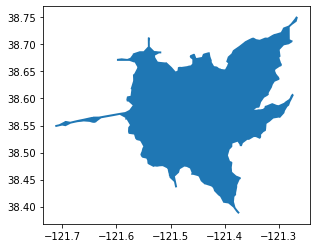

In [20]:
# Dissolve the multiple polygons into single polygon using Geopandas
gdf_diss = gdf_master.dissolve(by='value')

gdf_diss.plot()